# Spike And Burst Rate Simulation

#### Basic Scheme: The activation rates of an individual cell can be described by a drift diffusion equation, where the activation 

1. Gets a constant input signal
2. Is pulled towards some base value
3. Is pushed around randomly by noise

In additon, there is a rule where whenever the cells activation rises above some threshold, it spikes and the activation goes back to zero. The activation threshold is a function of the time since last spike. This threshold can be measured through in vitro experiments

In [44]:
should_run_simulations = True; #Determines if we run or load simulations
should_save_traces = False;
load_all_traces = True; #Load all the dorsal/ventral traces or only a single one
dummy_dorsal_ventral_thresh = False;


import numpy as np
import matplotlib.pyplot as plt
import os
import scipy as sp
import pickle
import scipy.stats
 
    

%matplotlib inline


def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        

def base_output_path(diff = 0, conv = 0):
    return 'BurstSimulationOutputs/Diff' + str(diff)+ '/'

# Load the and sanitize NSSTs
-----------
### NSSTs are contained in text files 'RDorsal.txt, RVentral.txt'. They're each labeled with a color ('b' or 'k'). They will be indexed by color later (not the best design decision)

/Users/samocko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/samocko/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/Users/samocko/anaconda2/lib/python2.7/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


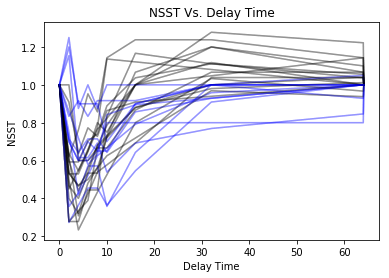

In [2]:
def sanitize_xy(x,y):
    #Jasons NSST data has some gaps. Here, if any value is not filled in, we delete it from the list
    ok_inds = np.int32(np.nonzero(np.isfinite(y))[0])
    (a_x, a_y) = (np.array(x), np.array(y))
#    print(ok_inds)
    return (a_x[ok_inds], a_y[ok_inds]);


decay_time_list  =[];

delay_times = [2,4,6,8,10,16,32,64];
delay_times = [0] + delay_times + [64.1]
color_list = []

refract_function_array = []; 
if(not load_all_traces):
    dorsal_thresh = [0.558817353,0.466306235,0.587025279,0.651660431,0.804890597,0.950352058,1.103304141,1.063730049]
    #dorsvent_thresh = [1, 0.656368686,0.537775619,0.639747922,0.705246938,0.767890476,0.920081746,1.010335905,1.002296956]
    ventral_thresh = [0.773570874,0.614242008,0.676114967,0.684071866,0.668619021,0.822488274,0.978920385,0.994989732]
    if(dummy_dorsal_ventral_thresh):
        dorsal_thresh = np.ones_like(dorsal_thresh)
        ventral_thresh = np.ones_like(ventral_thresh)    
    refract_function_array.append([1]  + list(dorsal_thresh) + [1] )
    color_list.append('k');
    refract_function_array.append([1] + list(ventral_thresh) + [1])
    color_list.append('b');
##Add in every individual cell
else:
    if(1):
        dorsal_array = np.genfromtxt('RDorsal.txt', delimiter= ',', missing_values=np.nan);
        for i in range(np.shape(dorsal_array)[0]):
    #        print(i)
            refract_function_array.append([1] + list(dorsal_array[i, :]) + [1])
            color_list.append('k');

    if(1):
        ventral_array = np.genfromtxt('RVentral.txt', delimiter= ',', missing_values=np.nan);
        for i in range(np.shape(ventral_array)[0]):
    #        print(i)
            refract_function_array.append([1] + list(ventral_array[i, :]) + [1])
            color_list.append('b');


for c in color_list:
    if(c =='k'):
       decay_time_list.append(8);
    else:
       decay_time_list.append(25);
            
plt.clf();
plt.hold(True)
for j in range(5):
    #PLotting things repeatedly with low alpha is a hack for achieving "Equal Visual Weighting"
    for i in range(len(refract_function_array)):
    #    #Plot the sanitized NSSTs 
        (san_delaytimes, san_refract_funct) = sanitize_xy(delay_times, refract_function_array[i])
        plt.plot(san_delaytimes, san_refract_funct, color_list[i], alpha = .1)
plt.title('NSST Vs. Delay Time')
plt.xlabel('Delay Time')
plt.ylabel('NSST')

plt.show()



# A few helper definitions


## Calculate N Bursts
### calculates the number of burst spikes from a list of spike times and a threshold(10 ms)




In [3]:

def calculate_n_bursts(spike_list, burst_time_thresh = 10):
    ISI_array = np.diff(np.array(spike_list))
#    print(ISI_array)

    below_thresh = ISI_array<burst_time_thresh; 
    n_bursts = np.sum(np.logical_or(below_thresh, np.roll(below_thresh, 1))) 
    #TODO(SAM) Probably Some Edge Effect in here, not gonna worry about that now
    
    return n_bursts;


## The bursting model

The meat is in here. It takes all the parameters, given by input_param_dict, and runs the model. Everything else is just scaffolding and plumbing around this function

In [4]:
def run_bursting_model(input_param_dict, path_name = '', output_raw_trace = False):
    print('Starting to run bursting model ...')
    delta_t = input_param_dict['delta_t']
    run_length = input_param_dict['run_length']
    diff_const = input_param_dict['diff_const']
#    burst_time_thresh  = input_param_dict['burst_time_thresh']
    input_signal = input_param_dict['input_signal']    
    decay_time = input_param_dict['decay_time']
    (delay_times, refract_threshs) = input_param_dict['refract_function'];
    
    
    
    t_range = np.linspace(0, run_length, run_length/delta_t)
    activation_list = np.zeros_like(t_range) + np.nan;
    thresh_list = np.zeros_like(t_range) + np.nan;    
    spike_time_list = [];
    i_spike_time_list = [];
    
    cur_activation = 0; 
    last_spike = -10000; #Just some really large negative number

    for (iT, t) in enumerate(t_range):
        cur_activation +=input_signal* delta_t +  np.sqrt(delta_t * diff_const)* np.random.randn(); 
        cur_activation *= (1-delta_t/decay_time)

        cur_thresh = np.interp(t - last_spike, delay_times, refract_threshs)
        activation_list[iT] = cur_activation;         
        thresh_list[iT] = cur_thresh;
        if(cur_activation > cur_thresh):
            cur_activation = 0;
            last_spike = t;
            spike_time_list.append(t);
            i_spike_time_list.append(iT);

    return_dict = dict([("i_spike_time_list", i_spike_time_list), ("spike_time_list", spike_time_list)])
    return_dict['path_name'] = path_name;   
    return_dict['run_length'] = input_param_dict['run_length'];         
    return_dict['input_signal'] = input_param_dict['input_signal']
    
    if(output_raw_trace):
        return_dict = dict([("i_spike_time_list", i_spike_time_list), ("spike_time_list", spike_time_list), ('activation_list', activation_list), ('thresh_list', thresh_list), ( 't_range', t_range)])
    
    print(' Finished bursting model')
    
    return return_dict

    

## Graphical Helpers

A few plotting functions that will be used later



In [5]:
def plot_activation_thresh_and_spikes(simulation_results_dict, plot_name = '', should_show = True):
    ## Plots the activation, the dynamic spiking threshold, and places dots at points where the neuron spiked. 
    plt.clf();
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')    
    plt.hold(True);         
    spike_time_list = simulation_results_dict['spike_time_list']
    i_spike_time_list = simulation_results_dict['i_spike_time_list']
    activation_list = simulation_results_dict['activation_list']
    t_range = simulation_results_dict['t_range']
    delta_t = np.mean(np.diff(t_range))
    thresh_list = simulation_results_dict['thresh_list']
    
    padded_i_spike_time_list = [0] + i_spike_time_list + [len(t_range)-1];
    
#    print(padded_i_spike_time_list)

    iT_pairs = np.transpose([padded_i_spike_time_list[0:-1], padded_i_spike_time_list[1:]])
    
    (min_act, max_act) = (np.min(activation_list), np.max(activation_list));

    for iT_pair in iT_pairs:
        (lb, ub) = tuple(iT_pair+1)
        ub = np.minimum(ub, len(t_range)-1);
#        print((lb, ub))
        plt.plot(t_range[lb:ub], activation_list[lb:ub], 'k', linewidth = 1)
        plt.plot(t_range[lb:ub], thresh_list[lb:ub], 'c', linewidth = 1)    
        if(ub < (len(t_range) -1)): #The end of the range is not a spike
            plt.plot((t_range[ub]-.5 *delta_t) * np.array([1,1]), (min_act, max_act), '--r', linewidth = 1)

    plt.scatter(np.array(spike_time_list), activation_list[i_spike_time_list], c = 'r')
#            plt.ylim(ymin = 0)
    plt.xlim(0, np.max(t_range))    
  #  plt.title('Signal is ' + str(Bias))
    plt.xlabel('Time(Millis)')
    plt.ylabel('Activation(Dimless)')
    plt.ylim(ymin =  min_act,ymax =  max_act)
    
    if(len(plot_name)>0):
        output_path = simulation_results_dict['path_name'] + plot_name #Loads the path from the dict
        ensure_dir(output_path)
        plt.savefig(output_path)
    if(should_show):
        plt.show()

    



def path_from_input_dict(input_dict):
    #Helper function for computing file paths
    return 'SimulationOutputs/IndividualTraces/' + 'CellType ' + str(input_dict['celltype']) + '/  DiffConst ' + str(input_dict['diff_const'])  + '/';


# Define parameters
All simulation are contained inside an input dictionary. We define an input dictionary (some values will be replaced in the for loop, some will not). In addition, we define signal and noise values that will be iterated over. 

In [6]:

burst_time_thresh = 10; #Defined in milliseconds. I doubt this will be changed. 

#The main object. This will be modified
input_dict = dict()
input_dict['delta_t'] = 1. #Will have this be larger for now so things run faster. 
input_dict['diff_const'] = .11; 
input_dict['run_length'] = 100;  
input_dict['decay_time'] = 25; #10 millisecond bursting threshold # (Jason: 10ms in dorsal, 30 in ventral??)
input_dict['input_signal'] = .02; 
input_dict['refract_function'] = (delay_times, refract_function_array[0])



#I have two sweeps. One is a really wide sweep, the other one is smaller and used for debugging
kahuna_sweep_params_dict = dict(); 
kahuna_sweep_params_dict['input_signal_range'] = np.linspace(-.25, .25, 30); #It seems like we don't need to go so high here to max out. This makes sense I think. 
#kahuna_sweep_params_dict['diff_const_range'] =[.01, .03, .05, .08,  .11]
kahuna_sweep_params_dict['diff_const_range'] =[.01, .02, .05, .09, .20]
#kahuna_sweep_params_dict['diff_const_range'] =[.05, .15]

#kahuna_sweep_params_dict['diff_const_range'] = np.linspace(.005, .105, 12)
kahuna_sweep_params_dict['run_length'] = 565 * 1000 * 1.;


debug_sweep_params_dict = dict()
debug_sweep_params_dict['input_signal_range'] = np.linspace(-.3, .15, 10); #It seems like we don't need to go so high here to max out. This makes sense I think.     
#    input_signal_range = np.linspace(-1., .15, 40); #It seems like we don't need to go so high here to max out. This makes sense I think. 
debug_sweep_params_dict['diff_const_range'] = [.05]
#debug_sweep_params_dict['diff_const_range'] = np.linspace(.005, .105, 3)
debug_sweep_params_dict['run_length'] = 100;



#sweep_params_dict = debug_sweep_params_dict; 
sweep_params_dict = kahuna_sweep_params_dict

sweep_params_dict['refract_function_array'] = refract_function_array; 
sweep_params_dict['decay_time_list'] = decay_time_list;
input_dict['run_length'] = sweep_params_dict['run_length']

del refract_function_array #All uses should come from the dictionary


## Mega for loop

Runs a bunch of simulations, fills up a giant data structure with the results. We also plot the raw traces from each simulation

##### We either generate the data structure, or simply load it through the should_run_simulations variable. Actually running them takes ~5 hours on my laptop. 

In [8]:

if(should_run_simulations):    
    print('Generating simulation data ...')
    spikes_and_bursts_dict = dict(); 
    for (i_diff_const, cur_diff_const) in enumerate(sweep_params_dict['diff_const_range']):
        input_dict['diff_const'] = cur_diff_const

        for (i_cell_type, cur_refract_function) in enumerate(sweep_params_dict['refract_function_array']):
            print('Doing Cell Type '+ str(i_cell_type))
            input_dict['refract_function'] = sanitize_xy(delay_times, cur_refract_function)
            input_dict['celltype'] = i_cell_type
            input_dict['decay_time'] = sweep_params_dict['decay_time_list'][i_cell_type]
            input_dict['diff_const'] = cur_diff_const * (10/input_dict['decay_time'])**0;
            
            n_spikes = [];
            n_bursts = [];
            for (i_signal, cur_signal) in enumerate(sweep_params_dict['input_signal_range']):
                ##Pack the dictionary
                input_dict['input_signal'] = cur_signal
                
                print('Diffus,  CellType, Sig are:' +str((i_diff_const, i_cell_type,  i_signal)) + '/' + 
                      str( (len(sweep_params_dict['diff_const_range']), len(sweep_params_dict['refract_function_array']),  len(sweep_params_dict['input_signal_range'])) ) ) 
                sim_results_dict = run_bursting_model(input_dict, path_from_input_dict(input_dict), should_save_traces);
                if(should_save_traces):
                    plot_activation_thresh_and_spikes(sim_results_dict, 'ActivThreshAndSpikes(iSig' + '{:d}'.format(i_signal).zfill(2)+ ')Signal' + '{0:.5f}'.format(cur_signal).zfill(5) + '.png', should_show = False)

                n_spikes.append(len(sim_results_dict['spike_time_list']))
                n_bursts.append(calculate_n_bursts(sim_results_dict['spike_time_list'], burst_time_thresh= burst_time_thresh))
            spikes_and_bursts_dict[(i_cell_type, cur_diff_const)] = (n_spikes, n_bursts);

    print('Saving simulation data ...')
    with open('SimulationOutputs.pickle', 'wb') as handle:
        pickle.dump([sweep_params_dict, spikes_and_bursts_dict], handle, protocol=pickle.HIGHEST_PROTOCOL)
            
else:
    print('Loading simulation data ...')    
    with open('SimulationOutputs.pickle', 'rb') as handle:
        [sweep_params_dict, spikes_and_bursts_dict] =  pickle.load(handle)
    print('Finished loading simulation data')
    

        

Generating simulation data ...
Doing Cell Type 0
Diffus,  CellType, Sig are:(0, 0, 0)/(5, 27, 30)
Starting to run bursting model ...


/Users/samocko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


 Finished bursting model
Diffus,  CellType, Sig are:(0, 0, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 0, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 0, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 0, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 0, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 0, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 0, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 0, 8)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 0, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting 

 Finished bursting model
Diffus,  CellType, Sig are:(0, 2, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 2, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 2, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 2, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 2, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 2, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 2, 22)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 2, 23)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 2, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished 

 Finished bursting model
Diffus,  CellType, Sig are:(0, 5, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 5, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 5, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 5, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 5, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 5, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 5, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 5, 8)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 5, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting 

 Finished bursting model
Diffus,  CellType, Sig are:(0, 7, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 7, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 7, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 7, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 7, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 7, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 7, 22)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 7, 23)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 7, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished 

 Finished bursting model
Diffus,  CellType, Sig are:(0, 10, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 10, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 10, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 10, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 10, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 10, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 10, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 10, 8)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 10, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished 

 Finished bursting model
Diffus,  CellType, Sig are:(0, 12, 15)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 12, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 12, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 12, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 12, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 12, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 12, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 12, 22)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 12, 23)/(5, 27, 30)
Starting to run bursting model ...
 

 Finished bursting model
Diffus,  CellType, Sig are:(0, 14, 29)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Doing Cell Type 15
Diffus,  CellType, Sig are:(0, 15, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 15, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 15, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 15, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 15, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 15, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 15, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 15, 7)/(5, 27, 30)
Starting to run bursting 

 Finished bursting model
Diffus,  CellType, Sig are:(0, 17, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 17, 14)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 17, 15)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 17, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 17, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 17, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 17, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 17, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 17, 21)/(5, 27, 30)
Starting to run bursting model ...
 

 Finished bursting model
Diffus,  CellType, Sig are:(0, 19, 27)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 19, 28)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 19, 29)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Doing Cell Type 20
Diffus,  CellType, Sig are:(0, 20, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 20, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 20, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 20, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 20, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 20, 5)/(5, 27, 30)
Starting to run burstin

 Finished bursting model
Diffus,  CellType, Sig are:(0, 22, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 22, 12)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 22, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 22, 14)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 22, 15)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 22, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 22, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 22, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 22, 19)/(5, 27, 30)
Starting to run bursting model ...
 

 Finished bursting model
Diffus,  CellType, Sig are:(0, 24, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 24, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 24, 27)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 24, 28)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 24, 29)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Doing Cell Type 25
Diffus,  CellType, Sig are:(0, 25, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 25, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 25, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(0, 25, 3)/(5, 27, 30)
Starting to run burst

 Finished bursting model
Diffus,  CellType, Sig are:(1, 0, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 0, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 0, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 0, 12)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 0, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 0, 14)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 0, 15)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 0, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 0, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished b

 Finished bursting model
Diffus,  CellType, Sig are:(1, 2, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 2, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 2, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 2, 27)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 2, 28)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 2, 29)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Doing Cell Type 3
Diffus,  CellType, Sig are:(1, 3, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 3, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 3, 2)/(5, 27, 30)
Starting to run bursting model

 Finished bursting model
Diffus,  CellType, Sig are:(1, 5, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 5, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 5, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 5, 12)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 5, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 5, 14)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 5, 15)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 5, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 5, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished b

 Finished bursting model
Diffus,  CellType, Sig are:(1, 7, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 7, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 7, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 7, 27)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 7, 28)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 7, 29)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Doing Cell Type 8
Diffus,  CellType, Sig are:(1, 8, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 8, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 8, 2)/(5, 27, 30)
Starting to run bursting model

 Finished bursting model
Diffus,  CellType, Sig are:(1, 10, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 10, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 10, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 10, 12)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 10, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 10, 14)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 10, 15)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 10, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 10, 17)/(5, 27, 30)
Starting to run bursting model ...
 F

 Finished bursting model
Diffus,  CellType, Sig are:(1, 12, 23)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 12, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 12, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 12, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 12, 27)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 12, 28)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 12, 29)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Doing Cell Type 13
Diffus,  CellType, Sig are:(1, 13, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 13, 1)/(5, 27, 30)
Starting to run bur

 Finished bursting model
Diffus,  CellType, Sig are:(1, 15, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 15, 8)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 15, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 15, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 15, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 15, 12)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 15, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 15, 14)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 15, 15)/(5, 27, 30)
Starting to run bursting model ...
 Fin

 Finished bursting model
Diffus,  CellType, Sig are:(1, 17, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 17, 22)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 17, 23)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 17, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 17, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 17, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 17, 27)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 17, 28)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 17, 29)/(5, 27, 30)
Starting to run bursting model ...
 

 Finished bursting model
Diffus,  CellType, Sig are:(1, 20, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 20, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 20, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 20, 8)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 20, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 20, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 20, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 20, 12)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 20, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finis

 Finished bursting model
Diffus,  CellType, Sig are:(1, 22, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 22, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 22, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 22, 22)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 22, 23)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 22, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 22, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 22, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 22, 27)/(5, 27, 30)
Starting to run bursting model ...
 

 Finished bursting model
Diffus,  CellType, Sig are:(1, 25, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 25, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 25, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 25, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 25, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 25, 8)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 25, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 25, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(1, 25, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finishe

 Finished bursting model
Diffus,  CellType, Sig are:(2, 0, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 0, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 0, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 0, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 0, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 0, 22)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 0, 23)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 0, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 0, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished 

 Finished bursting model
Diffus,  CellType, Sig are:(2, 3, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 3, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 3, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 3, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 3, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 3, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 3, 8)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 3, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 3, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting

 Finished bursting model
Diffus,  CellType, Sig are:(2, 5, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 5, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 5, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 5, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 5, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 5, 22)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 5, 23)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 5, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 5, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished 

 Finished bursting model
Diffus,  CellType, Sig are:(2, 8, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 8, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 8, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 8, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 8, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 8, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 8, 8)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 8, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 8, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting

 Finished bursting model
Diffus,  CellType, Sig are:(2, 10, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 10, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 10, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 10, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 10, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 10, 22)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 10, 23)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 10, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 10, 25)/(5, 27, 30)
Starting to run bursting model ...
 

 Finished bursting model
Diffus,  CellType, Sig are:(2, 13, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 13, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 13, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 13, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 13, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 13, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 13, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 13, 8)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 13, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished 

 Finished bursting model
Diffus,  CellType, Sig are:(2, 15, 15)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 15, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 15, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 15, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 15, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 15, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 15, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 15, 22)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 15, 23)/(5, 27, 30)
Starting to run bursting model ...
 

 Finished bursting model
Diffus,  CellType, Sig are:(2, 17, 29)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Doing Cell Type 18
Diffus,  CellType, Sig are:(2, 18, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 18, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 18, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 18, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 18, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 18, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 18, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 18, 7)/(5, 27, 30)
Starting to run bursting 

 Finished bursting model
Diffus,  CellType, Sig are:(2, 20, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 20, 14)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 20, 15)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 20, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 20, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 20, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 20, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 20, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 20, 21)/(5, 27, 30)
Starting to run bursting model ...
 

 Finished bursting model
Diffus,  CellType, Sig are:(2, 22, 27)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 22, 28)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 22, 29)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Doing Cell Type 23
Diffus,  CellType, Sig are:(2, 23, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 23, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 23, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 23, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 23, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 23, 5)/(5, 27, 30)
Starting to run burstin

 Finished bursting model
Diffus,  CellType, Sig are:(2, 25, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 25, 12)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 25, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 25, 14)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 25, 15)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 25, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 25, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 25, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(2, 25, 19)/(5, 27, 30)
Starting to run bursting model ...
 

 Finished bursting model
Diffus,  CellType, Sig are:(3, 0, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 0, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 0, 27)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 0, 28)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 0, 29)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Doing Cell Type 1
Diffus,  CellType, Sig are:(3, 1, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 1, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 1, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 1, 3)/(5, 27, 30)
Starting to run bursting model 

 Finished bursting model
Diffus,  CellType, Sig are:(3, 3, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 3, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 3, 12)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 3, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 3, 14)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 3, 15)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 3, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 3, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 3, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished 

 Finished bursting model
Diffus,  CellType, Sig are:(3, 5, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 5, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 5, 27)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 5, 28)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 5, 29)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Doing Cell Type 6
Diffus,  CellType, Sig are:(3, 6, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 6, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 6, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 6, 3)/(5, 27, 30)
Starting to run bursting model 

 Finished bursting model
Diffus,  CellType, Sig are:(3, 8, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 8, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 8, 12)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 8, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 8, 14)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 8, 15)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 8, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 8, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 8, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished 

 Finished bursting model
Diffus,  CellType, Sig are:(3, 10, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 10, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 10, 27)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 10, 28)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 10, 29)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Doing Cell Type 11
Diffus,  CellType, Sig are:(3, 11, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 11, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 11, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 11, 3)/(5, 27, 30)
Starting to run burst

 Finished bursting model
Diffus,  CellType, Sig are:(3, 13, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 13, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 13, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 13, 12)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 13, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 13, 14)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 13, 15)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 13, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 13, 17)/(5, 27, 30)
Starting to run bursting model ...
 F

 Finished bursting model
Diffus,  CellType, Sig are:(3, 15, 23)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 15, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 15, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 15, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 15, 27)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 15, 28)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 15, 29)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Doing Cell Type 16
Diffus,  CellType, Sig are:(3, 16, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 16, 1)/(5, 27, 30)
Starting to run bur

 Finished bursting model
Diffus,  CellType, Sig are:(3, 18, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 18, 8)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 18, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 18, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 18, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 18, 12)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 18, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 18, 14)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 18, 15)/(5, 27, 30)
Starting to run bursting model ...
 Fin

 Finished bursting model
Diffus,  CellType, Sig are:(3, 20, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 20, 22)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 20, 23)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 20, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 20, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 20, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 20, 27)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 20, 28)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 20, 29)/(5, 27, 30)
Starting to run bursting model ...
 

 Finished bursting model
Diffus,  CellType, Sig are:(3, 23, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 23, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 23, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 23, 8)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 23, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 23, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 23, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 23, 12)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 23, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finis

 Finished bursting model
Diffus,  CellType, Sig are:(3, 25, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 25, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 25, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 25, 22)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 25, 23)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 25, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 25, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 25, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(3, 25, 27)/(5, 27, 30)
Starting to run bursting model ...
 

 Finished bursting model
Diffus,  CellType, Sig are:(4, 1, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 1, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 1, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 1, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 1, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 1, 8)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 1, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 1, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 1, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finished burstin

 Finished bursting model
Diffus,  CellType, Sig are:(4, 3, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 3, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 3, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 3, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 3, 22)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 3, 23)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 3, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 3, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 3, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished 

 Finished bursting model
Diffus,  CellType, Sig are:(4, 6, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 6, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 6, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 6, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 6, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 6, 8)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 6, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 6, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 6, 11)/(5, 27, 30)
Starting to run bursting model ...
 Finished burstin

 Finished bursting model
Diffus,  CellType, Sig are:(4, 8, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 8, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 8, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 8, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 8, 22)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 8, 23)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 8, 24)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 8, 25)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 8, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished 

 Finished bursting model
Diffus,  CellType, Sig are:(4, 11, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 11, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 11, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 11, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 11, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 11, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 11, 8)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 11, 9)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 11, 10)/(5, 27, 30)
Starting to run bursting model ...
 Finished

 Finished bursting model
Diffus,  CellType, Sig are:(4, 13, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 13, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 13, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 13, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 13, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 13, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 13, 22)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 13, 23)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 13, 24)/(5, 27, 30)
Starting to run bursting model ...
 

 Finished bursting model
Doing Cell Type 16
Diffus,  CellType, Sig are:(4, 16, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 16, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 16, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 16, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 16, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 16, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 16, 6)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 16, 7)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 16, 8)/(5, 27, 30)
Starting to run bursting m

 Finished bursting model
Diffus,  CellType, Sig are:(4, 18, 14)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 18, 15)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 18, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 18, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 18, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 18, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 18, 20)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 18, 21)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 18, 22)/(5, 27, 30)
Starting to run bursting model ...
 

 Finished bursting model
Diffus,  CellType, Sig are:(4, 20, 28)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 20, 29)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Doing Cell Type 21
Diffus,  CellType, Sig are:(4, 21, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 21, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 21, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 21, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 21, 4)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 21, 5)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 21, 6)/(5, 27, 30)
Starting to run bursting

 Finished bursting model
Diffus,  CellType, Sig are:(4, 23, 12)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 23, 13)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 23, 14)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 23, 15)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 23, 16)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 23, 17)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 23, 18)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 23, 19)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 23, 20)/(5, 27, 30)
Starting to run bursting model ...
 

 Finished bursting model
Diffus,  CellType, Sig are:(4, 25, 26)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 25, 27)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 25, 28)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 25, 29)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Doing Cell Type 26
Diffus,  CellType, Sig are:(4, 26, 0)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 26, 1)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 26, 2)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 26, 3)/(5, 27, 30)
Starting to run bursting model ...
 Finished bursting model
Diffus,  CellType, Sig are:(4, 26, 4)/(5, 27, 30)
Starting to run bursti

# Plot The Data.

## First we just dump a gallery of individual responses 

#### Output Cell 1

/Users/samocko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if __name__ == '__main__':
/Users/samocko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


Loading Info (0, 0.01)


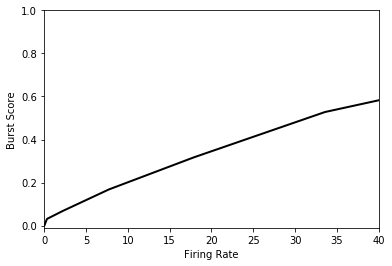

Loading Info (1, 0.01)


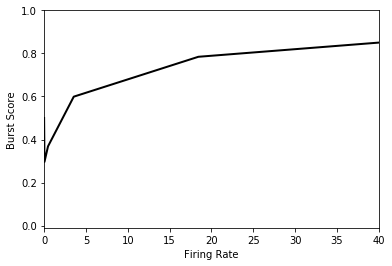

Loading Info (2, 0.01)


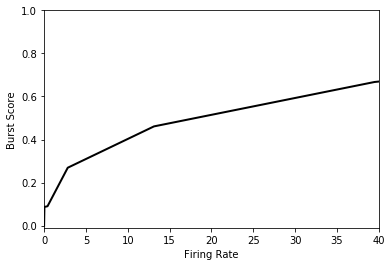

Loading Info (3, 0.01)


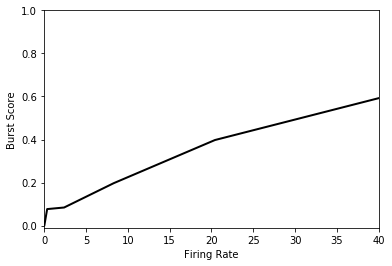

Loading Info (4, 0.01)


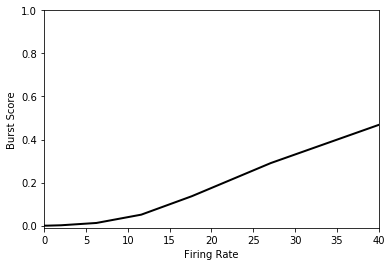

Loading Info (5, 0.01)


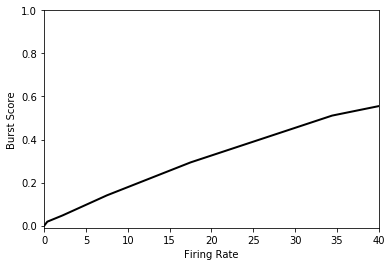

Loading Info (6, 0.01)


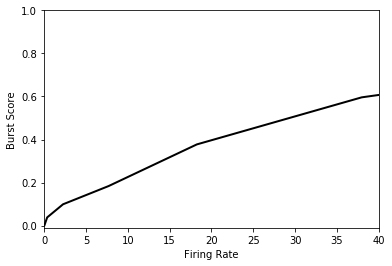

Loading Info (7, 0.01)


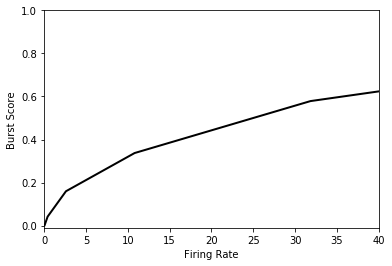

Loading Info (8, 0.01)


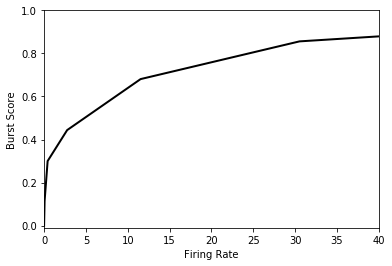

Loading Info (9, 0.01)


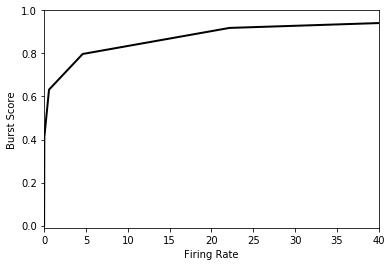

Loading Info (10, 0.01)


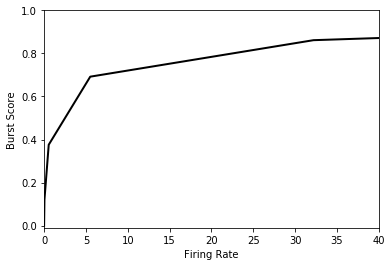

Loading Info (11, 0.01)


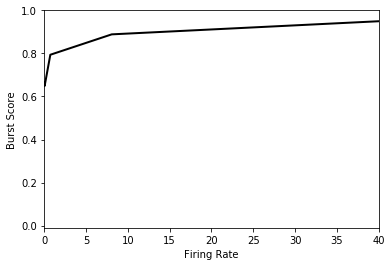

Loading Info (12, 0.01)


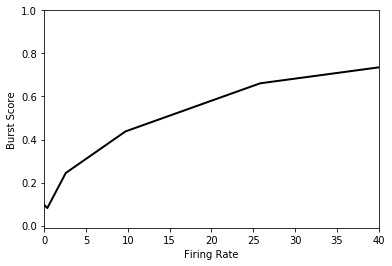

Loading Info (13, 0.01)


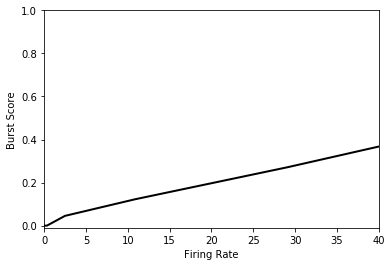

Loading Info (14, 0.01)


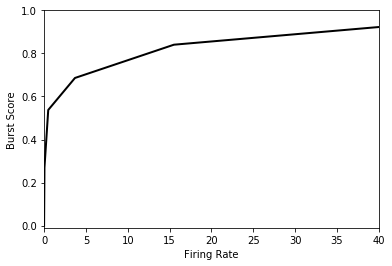

Loading Info (15, 0.01)


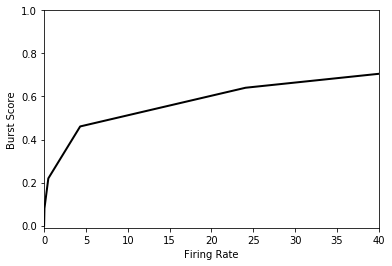

Loading Info (16, 0.01)


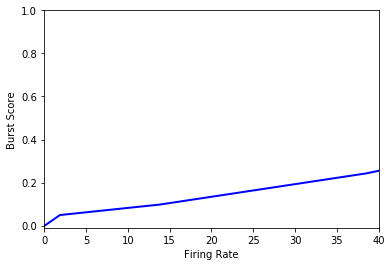

Loading Info (17, 0.01)


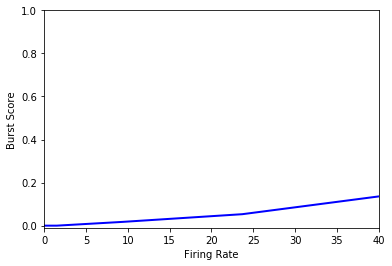

Loading Info (18, 0.01)


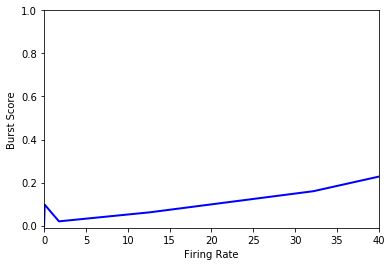

Loading Info (19, 0.01)


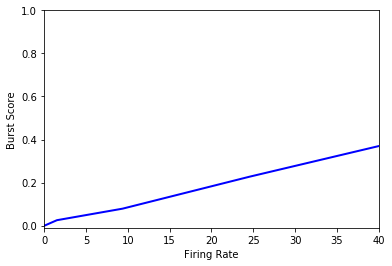

Loading Info (20, 0.01)


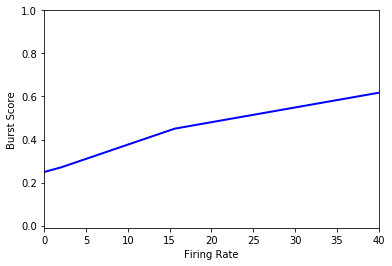

Loading Info (21, 0.01)


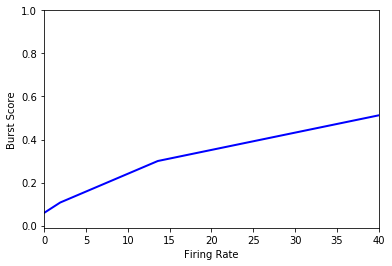

Loading Info (22, 0.01)


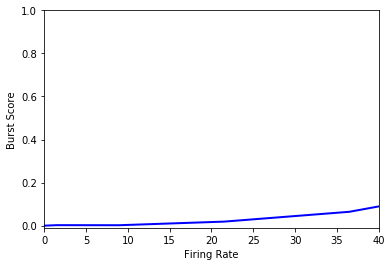

Loading Info (23, 0.01)


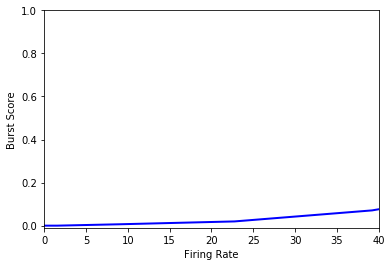

Loading Info (24, 0.01)


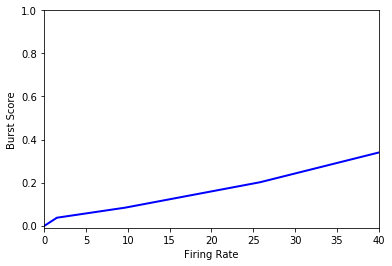

Loading Info (25, 0.01)


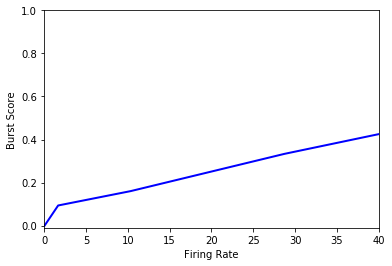

Loading Info (26, 0.01)


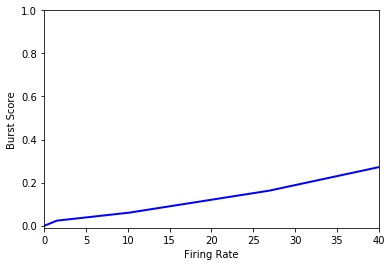

Loading Info (0, 0.02)


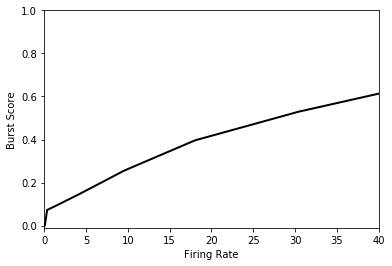

Loading Info (1, 0.02)


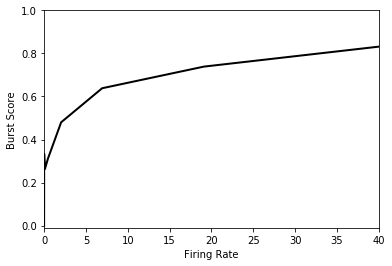

Loading Info (2, 0.02)


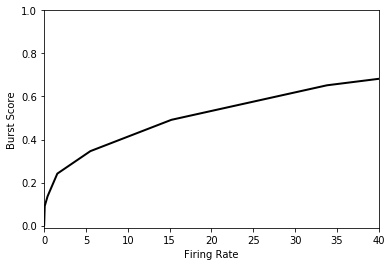

Loading Info (3, 0.02)


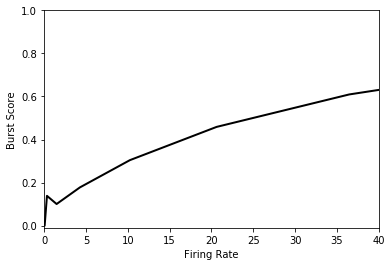

Loading Info (4, 0.02)


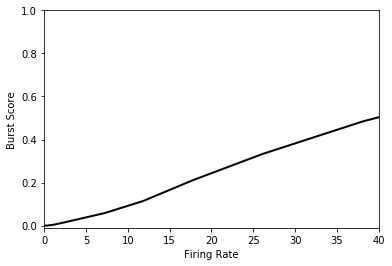

Loading Info (5, 0.02)


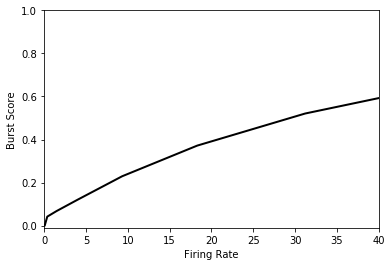

Loading Info (6, 0.02)


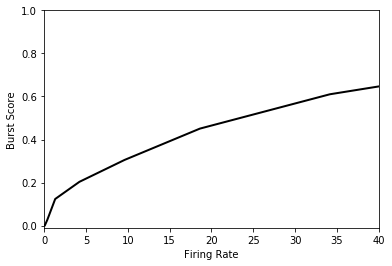

Loading Info (7, 0.02)


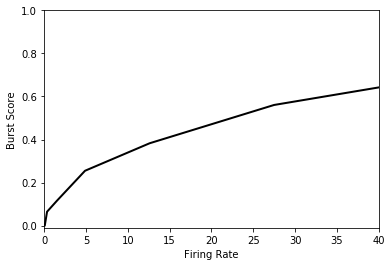

Loading Info (8, 0.02)


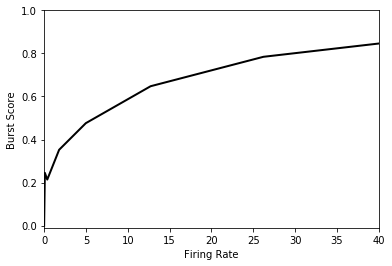

Loading Info (9, 0.02)


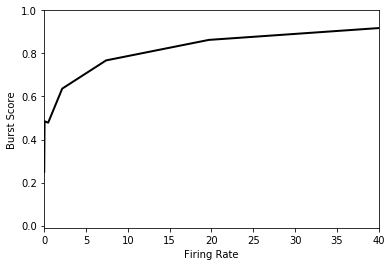

Loading Info (10, 0.02)


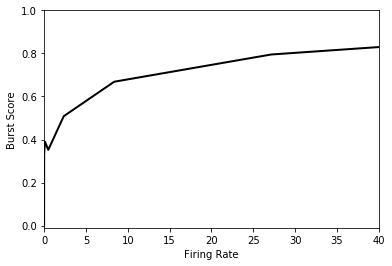

Loading Info (11, 0.02)


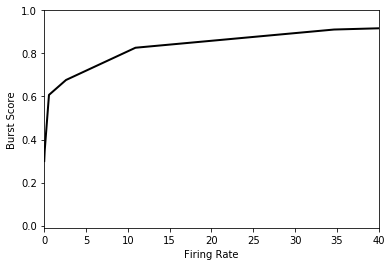

Loading Info (12, 0.02)


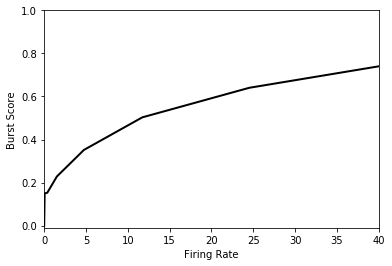

Loading Info (13, 0.02)


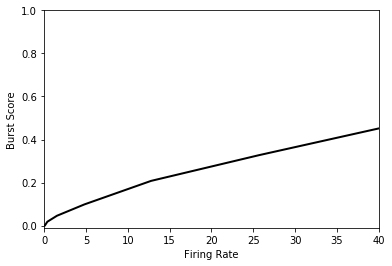

Loading Info (14, 0.02)


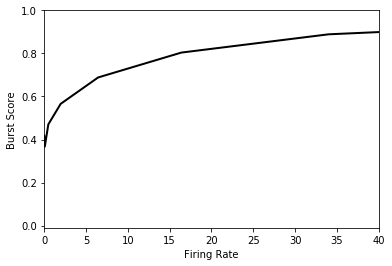

Loading Info (15, 0.02)


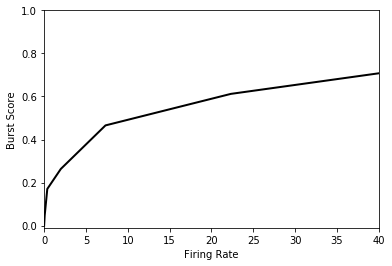

Loading Info (16, 0.02)


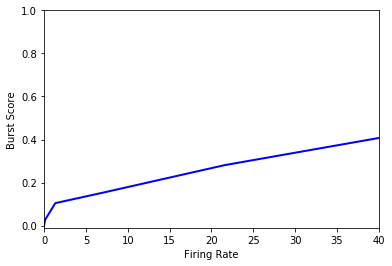

Loading Info (17, 0.02)


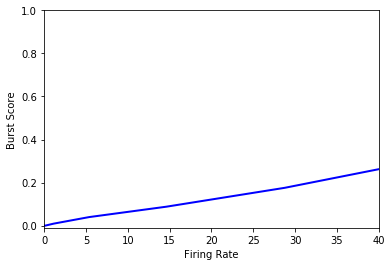

Loading Info (18, 0.02)


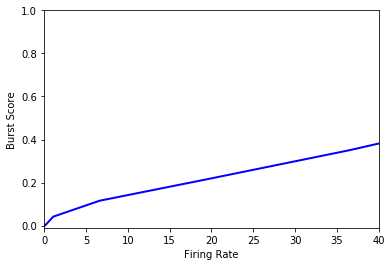

Loading Info (19, 0.02)


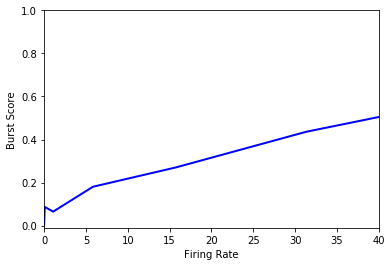

Loading Info (20, 0.02)


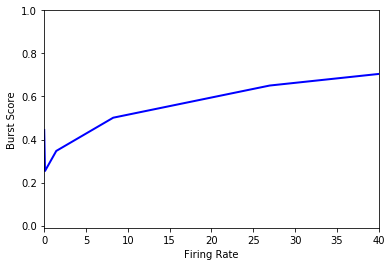

Loading Info (21, 0.02)


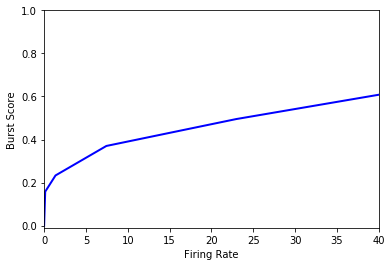

Loading Info (22, 0.02)


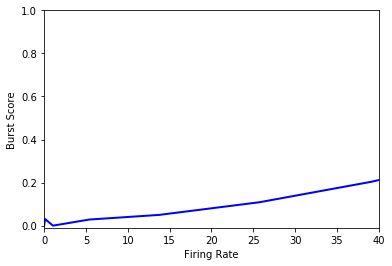

Loading Info (23, 0.02)


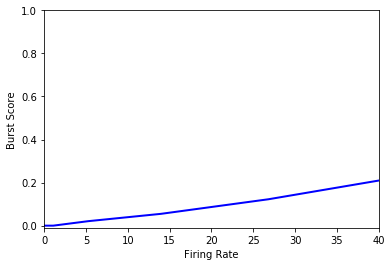

Loading Info (24, 0.02)


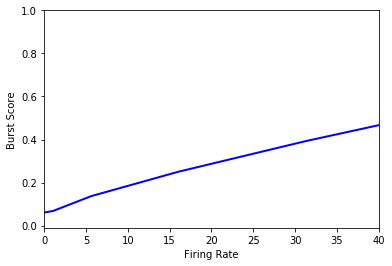

Loading Info (25, 0.02)


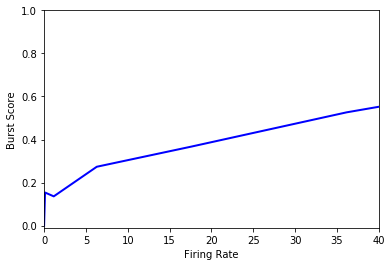

Loading Info (26, 0.02)


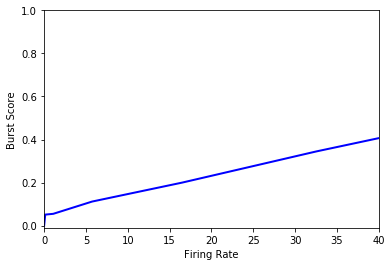

Loading Info (0, 0.05)


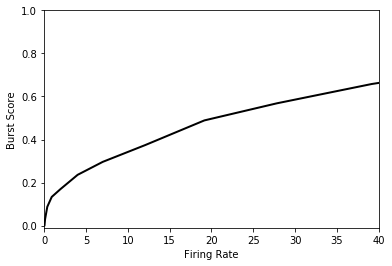

Loading Info (1, 0.05)


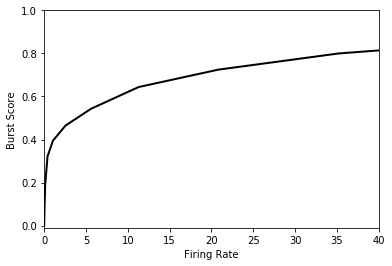

Loading Info (2, 0.05)


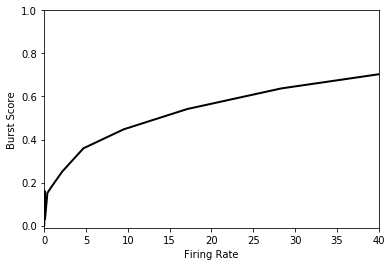

Loading Info (3, 0.05)


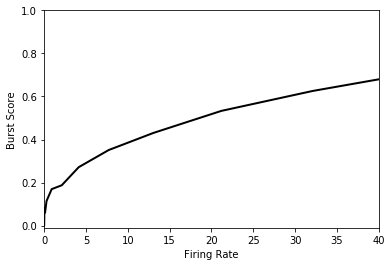

Loading Info (4, 0.05)


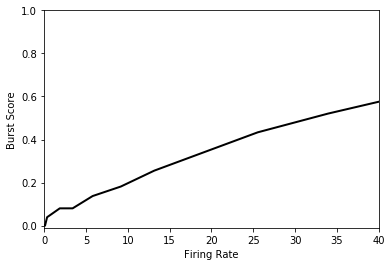

Loading Info (5, 0.05)


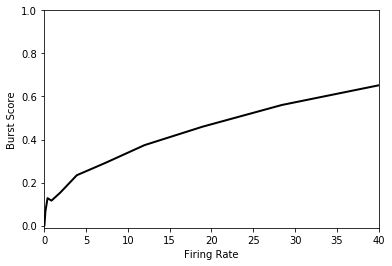

Loading Info (6, 0.05)


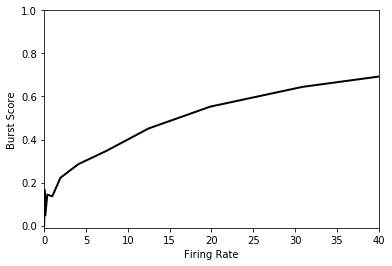

Loading Info (7, 0.05)


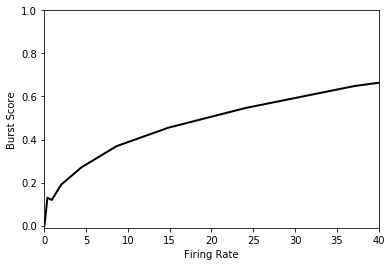

Loading Info (8, 0.05)


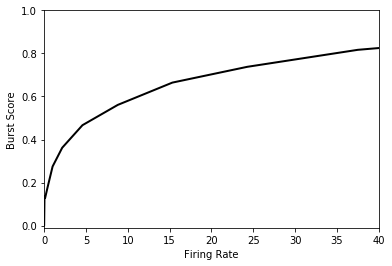

Loading Info (9, 0.05)


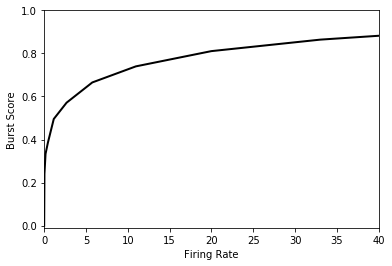

Loading Info (10, 0.05)


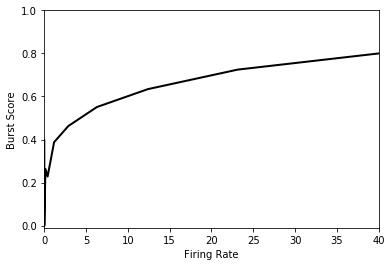

Loading Info (11, 0.05)


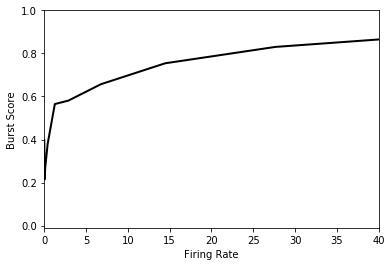

Loading Info (12, 0.05)


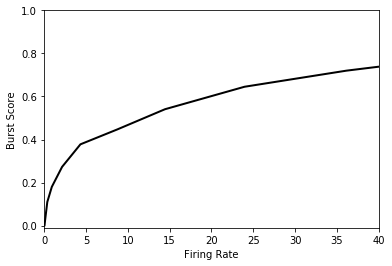

Loading Info (13, 0.05)


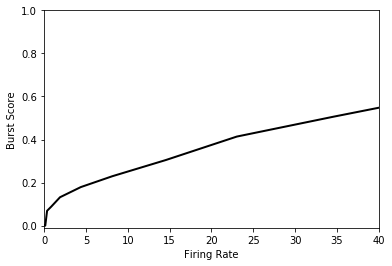

Loading Info (14, 0.05)


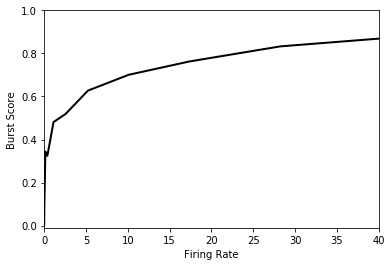

Loading Info (15, 0.05)


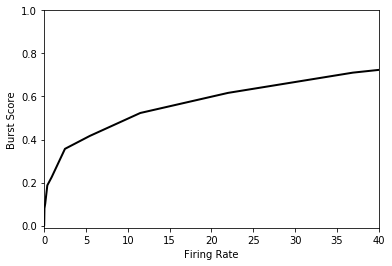

Loading Info (16, 0.05)


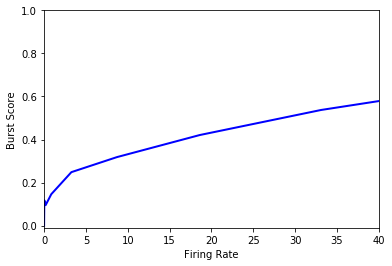

Loading Info (17, 0.05)


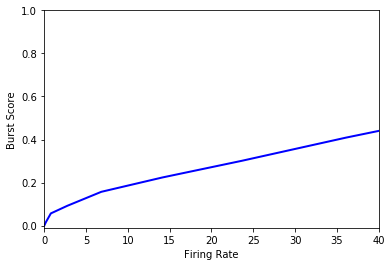

Loading Info (18, 0.05)


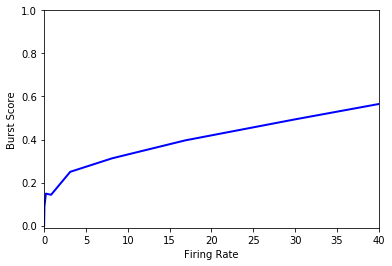

Loading Info (19, 0.05)


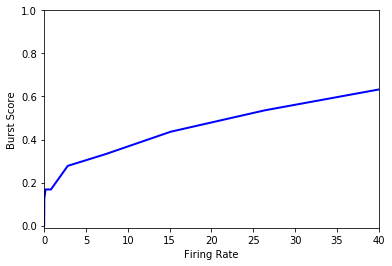

Loading Info (20, 0.05)


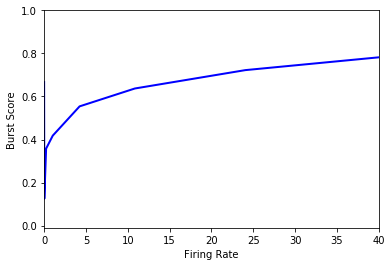

Loading Info (21, 0.05)


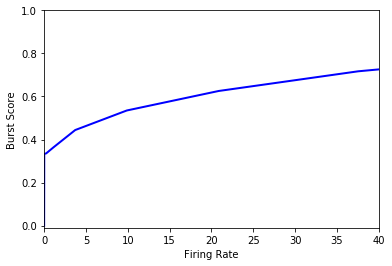

Loading Info (22, 0.05)


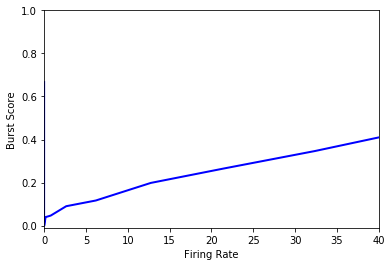

Loading Info (23, 0.05)


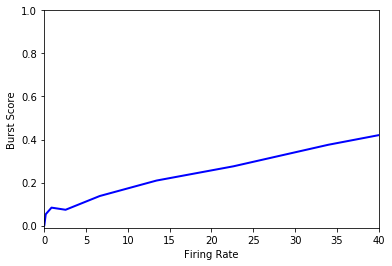

Loading Info (24, 0.05)


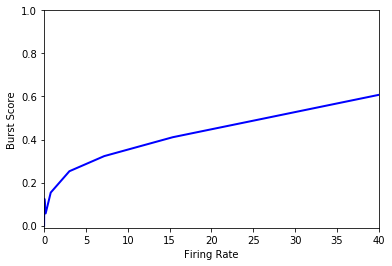

Loading Info (25, 0.05)


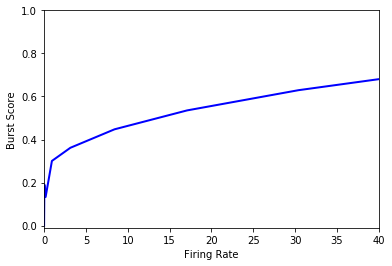

Loading Info (26, 0.05)


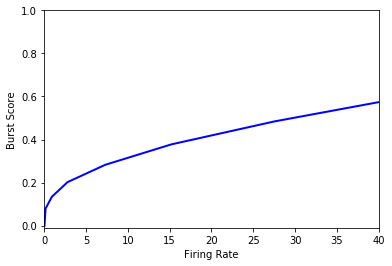

Loading Info (0, 0.09)


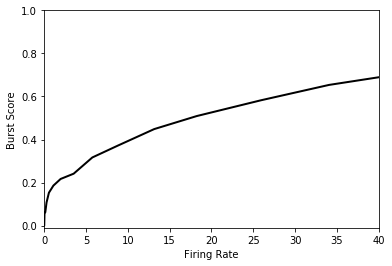

Loading Info (1, 0.09)


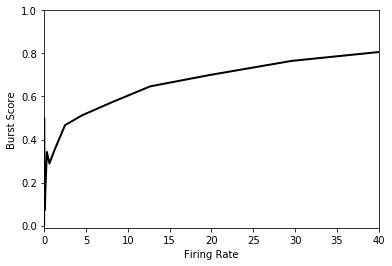

Loading Info (2, 0.09)


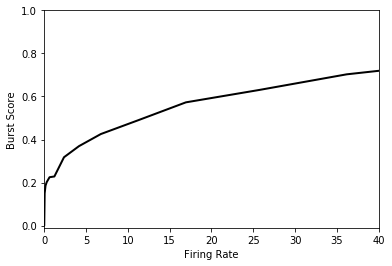

Loading Info (3, 0.09)


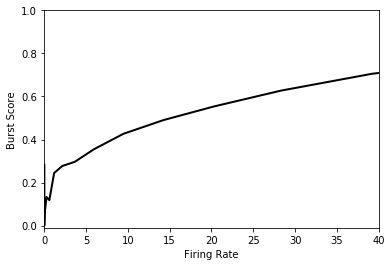

Loading Info (4, 0.09)


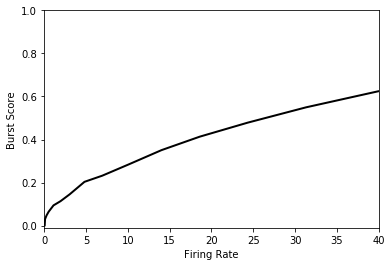

Loading Info (5, 0.09)


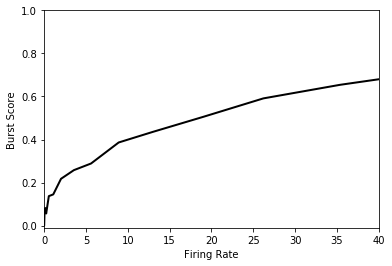

Loading Info (6, 0.09)


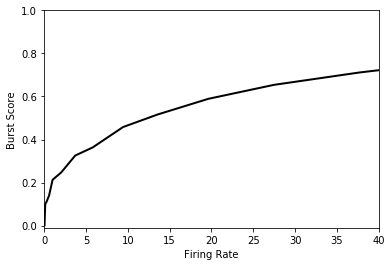

Loading Info (7, 0.09)


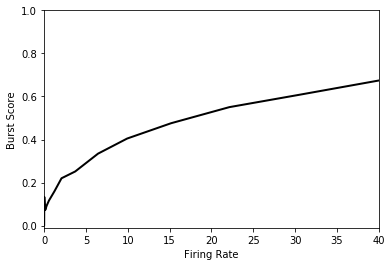

Loading Info (8, 0.09)


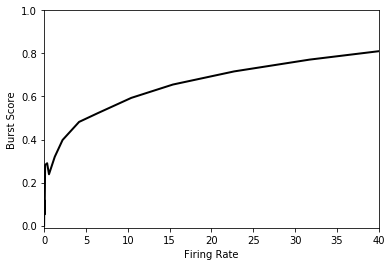

Loading Info (9, 0.09)


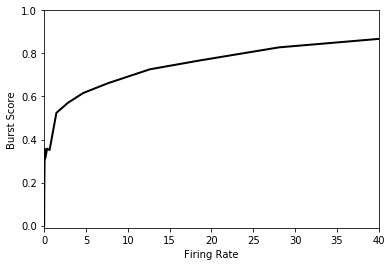

Loading Info (10, 0.09)


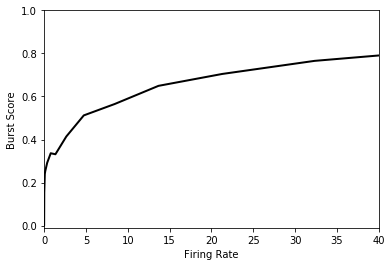

Loading Info (11, 0.09)


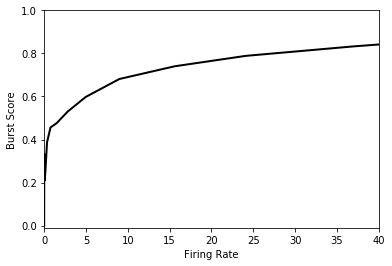

Loading Info (12, 0.09)


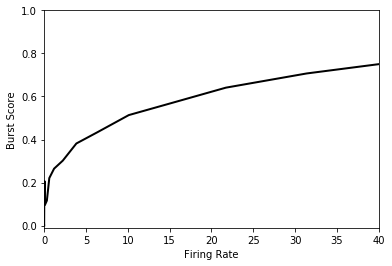

Loading Info (13, 0.09)


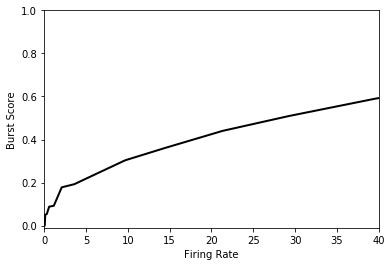

Loading Info (14, 0.09)


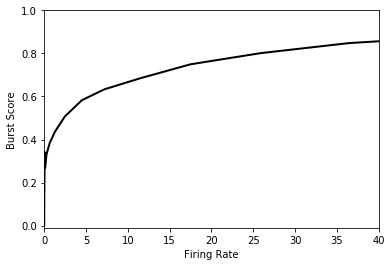

Loading Info (15, 0.09)


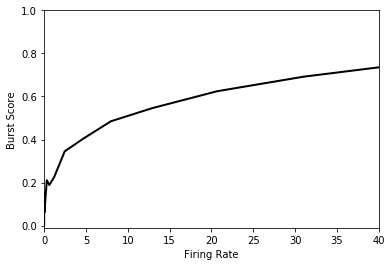

Loading Info (16, 0.09)


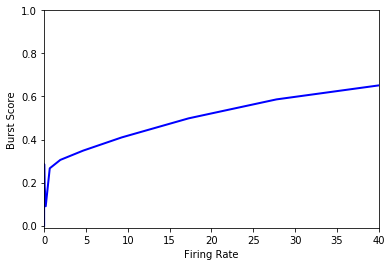

Loading Info (17, 0.09)


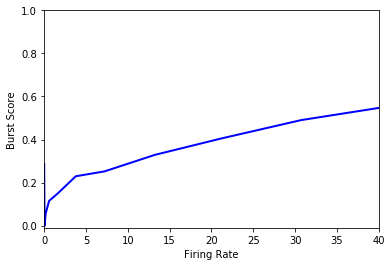

Loading Info (18, 0.09)


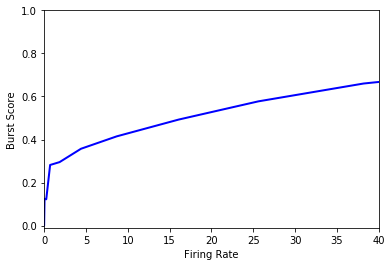

Loading Info (19, 0.09)


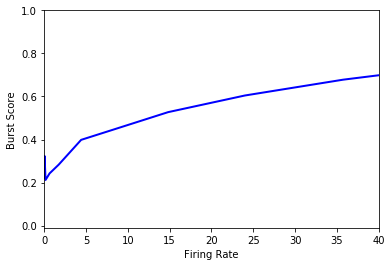

Loading Info (20, 0.09)


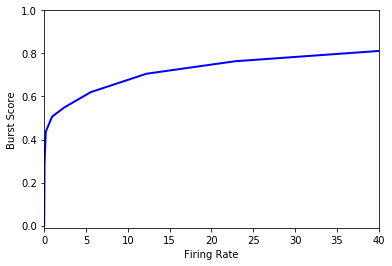

Loading Info (21, 0.09)


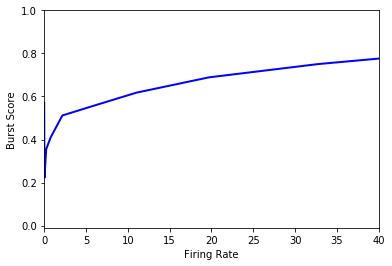

Loading Info (22, 0.09)


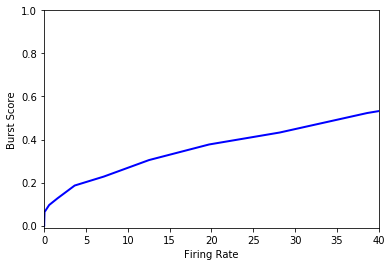

Loading Info (23, 0.09)


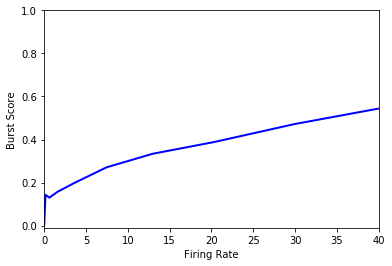

Loading Info (24, 0.09)


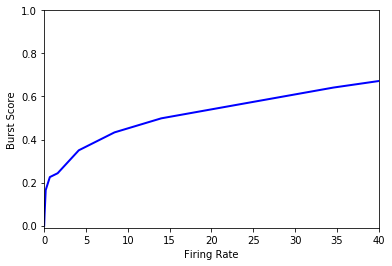

Loading Info (25, 0.09)


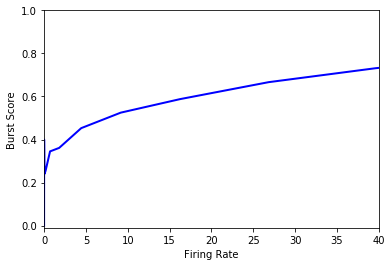

Loading Info (26, 0.09)


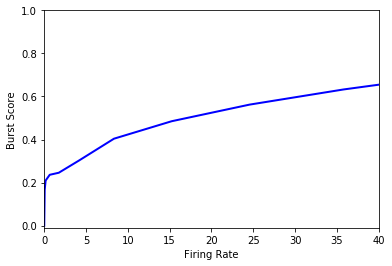

Loading Info (0, 0.2)


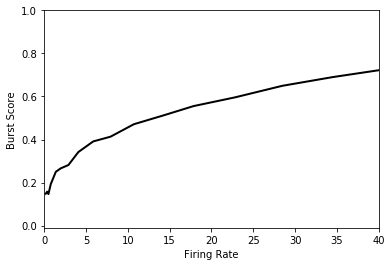

Loading Info (1, 0.2)


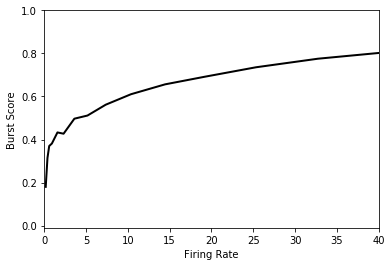

Loading Info (2, 0.2)


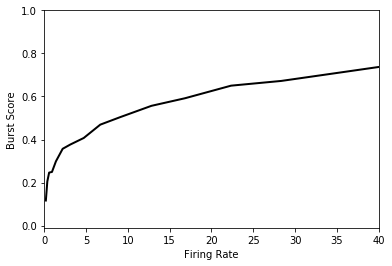

Loading Info (3, 0.2)


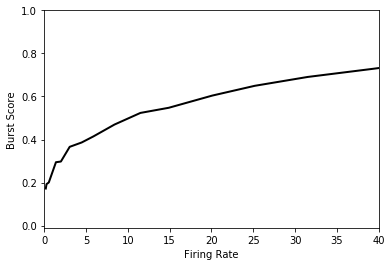

Loading Info (4, 0.2)


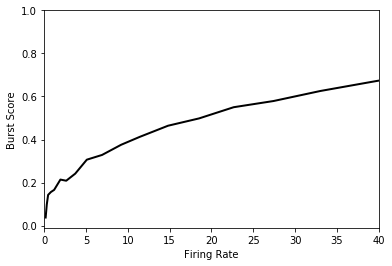

Loading Info (5, 0.2)


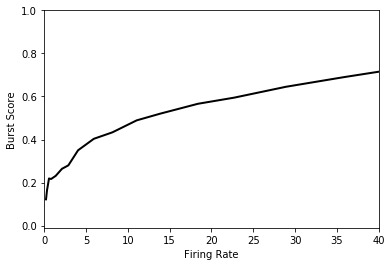

Loading Info (6, 0.2)


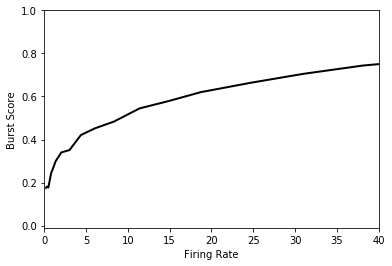

Loading Info (7, 0.2)


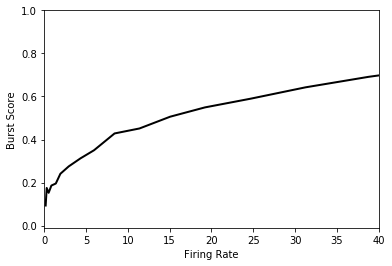

Loading Info (8, 0.2)


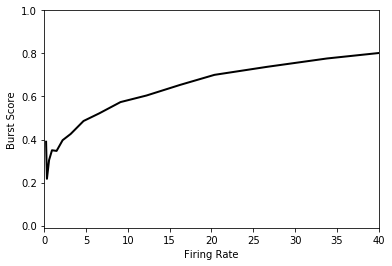

Loading Info (9, 0.2)


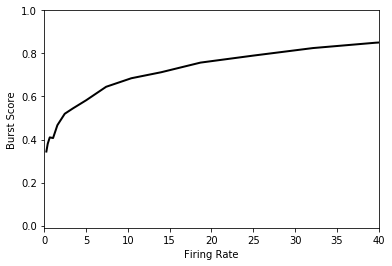

Loading Info (10, 0.2)


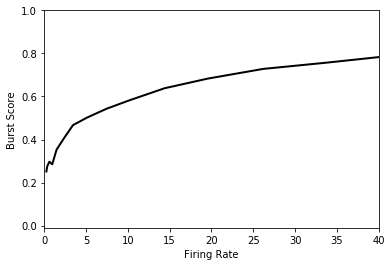

Loading Info (11, 0.2)


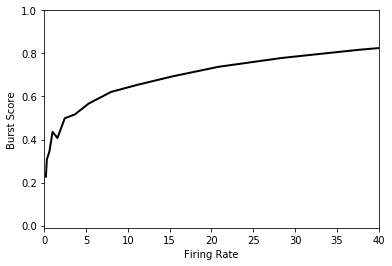

Loading Info (12, 0.2)


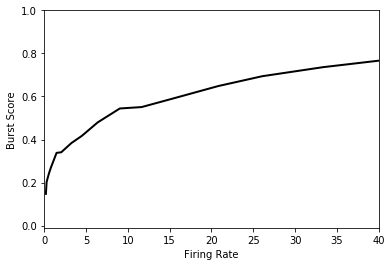

Loading Info (13, 0.2)


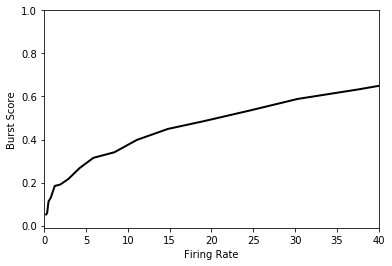

Loading Info (14, 0.2)


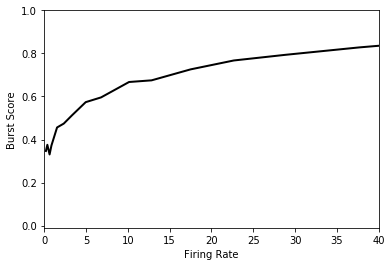

Loading Info (15, 0.2)


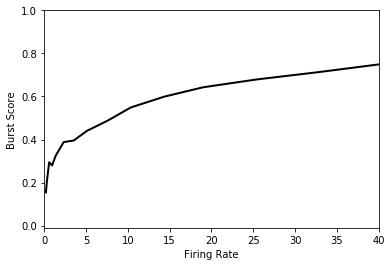

Loading Info (16, 0.2)


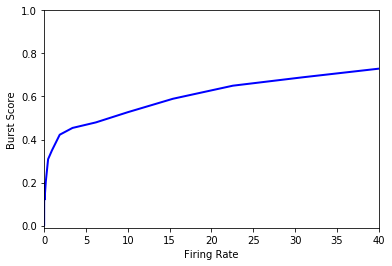

Loading Info (17, 0.2)


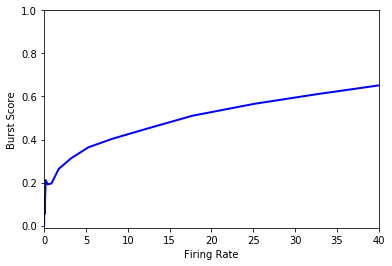

Loading Info (18, 0.2)


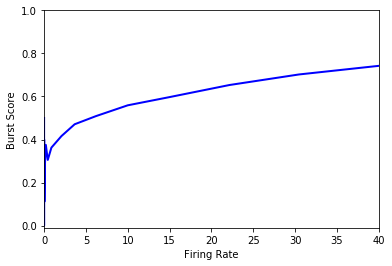

Loading Info (19, 0.2)


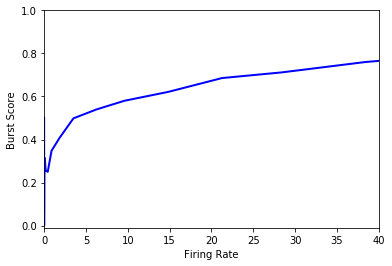

Loading Info (20, 0.2)


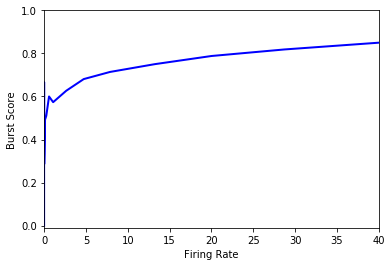

Loading Info (21, 0.2)


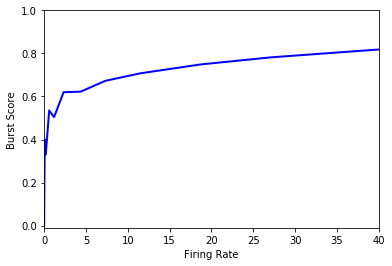

Loading Info (22, 0.2)


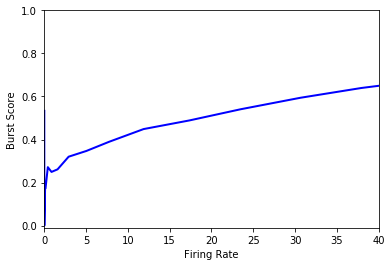

Loading Info (23, 0.2)


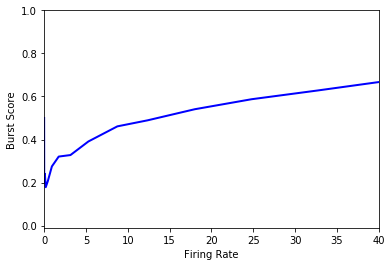

Loading Info (24, 0.2)


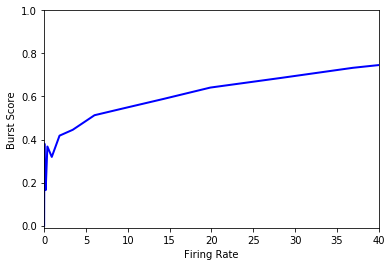

Loading Info (25, 0.2)


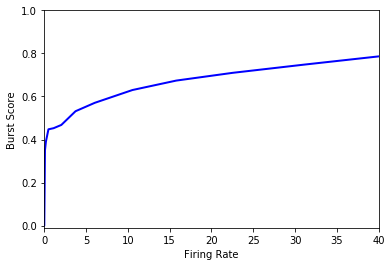

Loading Info (26, 0.2)


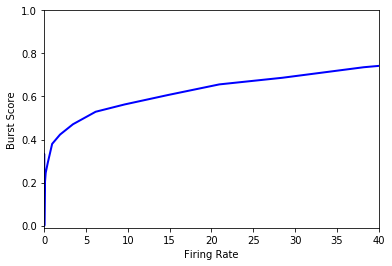

<Figure size 432x288 with 0 Axes>

In [45]:
#For all values of noise, and for all values of conv (the variation on the levels of signal), we create a list of interpolated burst scores. 
#This gives us two array of interpolated burst scoress, one for dorsal, and one for ventral. 

for (i_diff_const, cur_diff_const) in enumerate(sweep_params_dict['diff_const_range']):

    firing_rate_range  = np.linspace(0, 40, 40)

    plt.clf();
    plt.hold('True');           
    #Gather all cells into the data structure. 
    for (i_cell_type, cur_refract_function) in enumerate(sweep_params_dict['refract_function_array']):        
        color_key = color_list[i_cell_type];
        print("Loading Info " + str((i_cell_type, cur_diff_const)))
        (n_spikes, n_bursts) = spikes_and_bursts_dict[(i_cell_type, cur_diff_const)];
        burst_rate = np.array(n_bursts) * 1000./sweep_params_dict['run_length'];
        burst_score = np.array(n_bursts) * 1./np.array(n_spikes)
#        burst_score[np.nonzero(n_spikes ==0)] = 0;
        burst_score[np.nonzero(n_spikes ==0)] = 0;

        firing_rate = np.array(n_spikes) * 1000./sweep_params_dict['run_length'];
        plt.plot(firing_rate, burst_score, color_list[i_cell_type], alpha = 1., linewidth = 2.0)
        plt.ylim(ymin = -.01, ymax = 1);
        
        #We ploot the raw spikes vs the raw bursts. No interpolation.#TODO-Figure out why it's so non-monotonic. Is this just statistical noise? View these things as an ensemble
        plt.xlabel('Firing Rate')
        plt.ylabel('Burst Score')

        output_path = base_output_path(cur_diff_const) + 'UncroppedEnsembleGallery/EnsembleBurstVsSpikeCell '+ str(i_cell_type) +  '.pdf'
        ensure_dir(output_path)
        plt.savefig(output_path)
        plt.xlim(xmin = 0, xmax = 40);
        output_path = base_output_path(cur_diff_const) + 'CroppedEnsembleGallery/EnsembleBurstVsSpikeCell '+ str(i_cell_type) +  '.pdf'
        ensure_dir(output_path)
        plt.savefig(output_path)
        plt.show()
        plt.clf()
        
        output_path = base_output_path(cur_diff_const) + 'FiringVsSig/Cell'+ str(i_cell_type) +  'FiringVsSig.pdf'
        ensure_dir(output_path)
        plt.plot(sweep_params_dict['input_signal_range'],  firing_rate, c=  color_list[i_cell_type] )
        plt.savefig(output_path)
        plt.clf();

        output_path = base_output_path(cur_diff_const) + 'FiringVsSig/Cell'+ str(i_cell_type) +  'BurstRateVsSig.pdf'
        ensure_dir(output_path)
        plt.plot(sweep_params_dict['input_signal_range'],  burst_rate, c=  color_list[i_cell_type] )
        plt.savefig(output_path)
        plt.clf();        



# Plot The Data.



## First we just dump a gallery of individual responses (TODO-Write this). Then we plot the general statistics

#### Output Cell 2

/Users/samocko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  del sys.path[0]
/Users/samocko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide
/Users/samocko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in divide


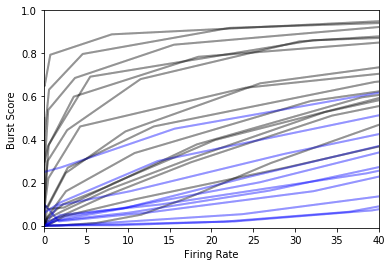

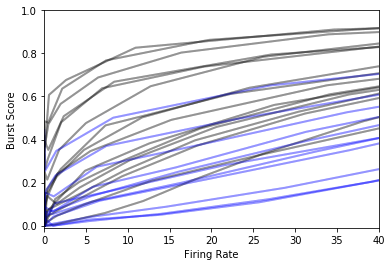

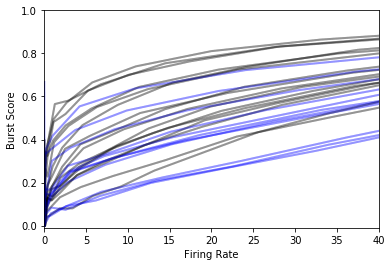

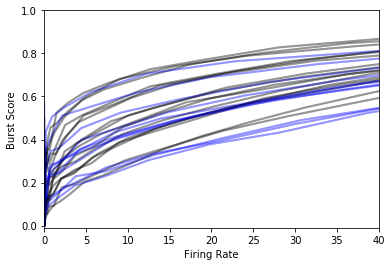

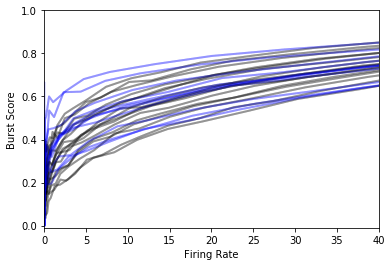

<Figure size 432x288 with 0 Axes>

In [46]:
#For all values of noise, and for all values of conv (the variation on the levels of signal), we create a list of interpolated burst scores. 
#This gives us two array of interpolated burst scoress, one for dorsal, and one for ventral. 

all_averaging_dicts = dict();
for (i_diff_const, cur_diff_const) in enumerate(sweep_params_dict['diff_const_range']):
#    for i_convolve in range(1, len(sweep_params_dict['input_signal_range'])):
    for i_convolve in [1]: #I don't think we want to use this, but let's keep it around
        
        my_averaging_dict = dict(); 
        firing_rate_range  = np.linspace(0, 40, 40)

        plt.clf();
        plt.hold('True');           
        #Gather all cells into the data structure. 
        for foo in range(5): #My alpha trick
            for (i_cell_type, cur_refract_function) in enumerate(sweep_params_dict['refract_function_array']):        
                color_key = color_list[i_cell_type];
                if(not  color_key in my_averaging_dict.keys()):
                    my_averaging_dict[color_list[i_cell_type]] = [];

                (n_spikes, n_bursts) = spikes_and_bursts_dict[(i_cell_type, cur_diff_const)]; 
                conv_spikes = np.convolve(n_spikes,  np.ones(i_convolve), mode = 'same')/np.convolve(np.ones_like(n_spikes),np.ones(i_convolve), mode = 'same');
                conv_bursts = np.convolve(n_bursts,  np.ones(i_convolve), mode = 'same')/np.convolve(np.ones_like(n_bursts),np.ones(i_convolve), mode = 'same')
                conv_burst_score = np.array(conv_bursts)/np.array(conv_spikes);
                conv_burst_score[np.nonzero(conv_spikes == 0)] = 0; 

                conv_firing_rate = conv_spikes * 1000./sweep_params_dict['run_length']; 
                interp_burst_score = np.interp(firing_rate_range, conv_firing_rate, conv_burst_score);
                if(foo  == 0): #To prevent double plotting
                    my_averaging_dict[color_key].append(interp_burst_score)
                plt.plot(np.array(conv_spikes)* 1000./sweep_params_dict['run_length'], np.array(conv_bursts)/np.array(conv_spikes), color_list[i_cell_type], alpha = .1, linewidth = 2.0)
                #We ploot the raw spikes vs the raw bursts. No interpolation.#TODO-Figure out why it's so non-monotonic. Is this just statistical noise? View these things as an ensemble
        plt.xlim(xmin = 0, xmax = 40);
        plt.ylim(ymin = -.01, ymax = 1);
        plt.xlabel('Firing Rate')
        plt.ylabel('Burst Score')

        output_path = base_output_path(cur_diff_const, i_convolve) + 'EnsembleAllTogether/' + 'EnsembleBurstVsSpike/AllTogether'  + '.pdf'
#            'SimulationOutputs/Diff/BurstVsSpike/ ' +  str(cur_diff_const) + 'EnsembleGallery/' + 'EnsembleBurstVsSpike/' +  'Conv ' + str(i_convolve).zfill(2) + '.pdf'
        ensure_dir(output_path)
        plt.savefig(output_path)
        plt.show()

        plt.clf(); 
    all_averaging_dicts[cur_diff_const] = my_averaging_dict;
        

## Perform a statistical test of the burstiness of dorsal vs ventral cells

#### Output Cell 3

/Users/samocko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide


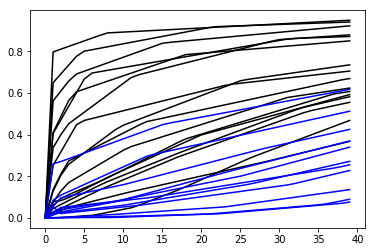

[0.17647415259623833, 0.07700238978549015, 0.14041509983749625, 0.24879995749647366, 0.5236203023176341, 0.4037836265960963, 0.040737372338017046, 0.03819293330505233, 0.22205479859855784, 0.3137104414341589, 0.17261891463681167]
[0.43238563165831223, 0.7981103094651263, 0.5643736244971336, 0.45154453574703013, 0.2840925028922166, 0.40882398298153744, 0.4649663975041653, 0.5102246561397823, 0.8025760494607919, 0.9114598049754361, 0.8185653602963564, 0.9235244589562359, 0.6345158566393684, 0.25592628713270604, 0.8713706152356593, 0.6373911550793975]
Comparing 11Vs.16Cells


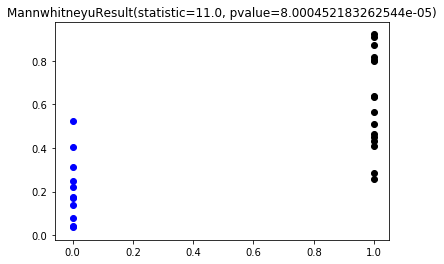

MannwhitneyuResult(statistic=11.0, pvalue=8.000452183262544e-05)


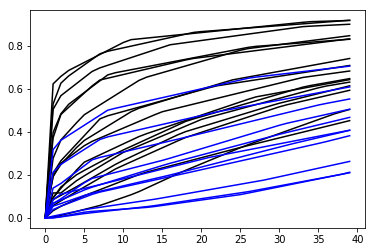

[0.314330443824491, 0.17009078882894435, 0.27556682681272937, 0.3855931254033527, 0.6339886377113255, 0.5172511236260954, 0.12660956391053552, 0.1297898063385001, 0.3497988352360298, 0.4464806979405955, 0.2943938794425935]
[0.48047739151187124, 0.7667272081123817, 0.5844018333692669, 0.5071330217845812, 0.33654273753156677, 0.4595961854066779, 0.5247495507936515, 0.532094166131242, 0.7616698915432184, 0.8732491723792645, 0.7757032052872963, 0.8778498589422867, 0.6395928818290633, 0.3349673559853407, 0.8450310060489965, 0.6253355361496352]
Comparing 11Vs.16Cells


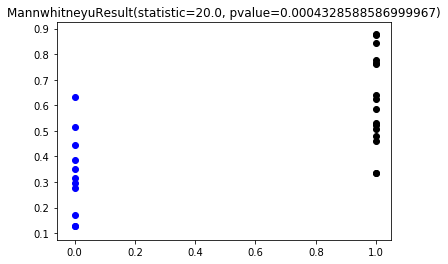

MannwhitneyuResult(statistic=20.0, pvalue=0.0004328588586999967)


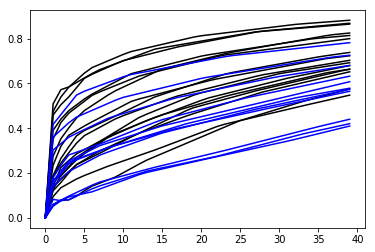

[0.4822453664099629, 0.33047113366277153, 0.4682182134937296, 0.5304926987607782, 0.7237182033154591, 0.652293160349262, 0.3057056675168678, 0.3148570552487594, 0.5011222447394852, 0.5974084505024562, 0.47128202429761623]
[0.5460911333051015, 0.7464883726440353, 0.6110901692813304, 0.5699432617886001, 0.43260460253441024, 0.5322265072536883, 0.5945340602718351, 0.558795416294043, 0.7401052191015447, 0.8289463587984077, 0.7292714161839535, 0.8110307969935064, 0.6460055408746685, 0.4336552870854691, 0.8092035844289853, 0.6391362525542039]
Comparing 11Vs.16Cells


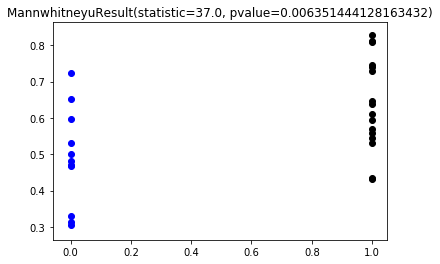

MannwhitneyuResult(statistic=37.0, pvalue=0.006351444128163432)


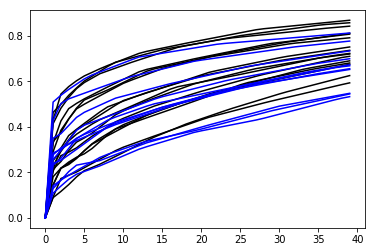

[0.5658571590667557, 0.4483276229410948, 0.5764848982854387, 0.6134156230035652, 0.765687511676168, 0.7151889824990436, 0.4248118405918758, 0.44237906025249263, 0.5839023331484225, 0.655521381745164, 0.5670605728733842]
[0.5804039186919153, 0.7355419131329936, 0.6309087765796052, 0.6033458905353482, 0.4943915904594431, 0.575515141395678, 0.6312827663715923, 0.5718607661932845, 0.7301197493382074, 0.8069650154690725, 0.7241579208843184, 0.7874491679122195, 0.6625598132447031, 0.48004999183117275, 0.7930090907139622, 0.6533727047293374]
Comparing 11Vs.16Cells


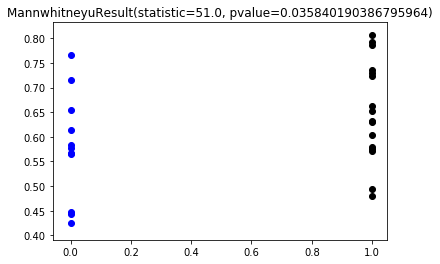

MannwhitneyuResult(statistic=51.0, pvalue=0.035840190386795964)


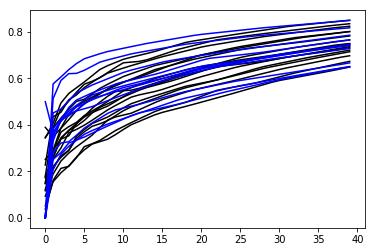

[0.6590338013704996, 0.5668456575704908, 0.6724784404440515, 0.698142571647403, 0.8055949946894045, 0.7732308751060256, 0.5600245025780776, 0.5895967698986426, 0.6722469046317452, 0.7235038100553669, 0.6752681005686955]
[0.6228064215702469, 0.7320436591569726, 0.6563834134002359, 0.6460974141535625, 0.5670461128589923, 0.6205665573241911, 0.6671279154073064, 0.5992868956326575, 0.7252024296694609, 0.7891561907899112, 0.71417692315741, 0.7594728156103716, 0.682896035548018, 0.5468932476970108, 0.7719794941290362, 0.6742657974643924]
Comparing 11Vs.16Cells


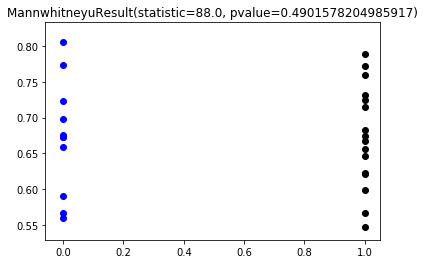

MannwhitneyuResult(statistic=88.0, pvalue=0.4901578204985917)


In [47]:

###MY STATISTICAL TEST
plt.clf()

for (i_diff_const, cur_diff_const) in enumerate(sweep_params_dict['diff_const_range']):
    my_mean_burst_averaging_dict = dict();

    
    for (i_cell_type, cur_refract_function) in enumerate(sweep_params_dict['refract_function_array']):        
        (spikes, bursts) = spikes_and_bursts_dict[(i_cell_type, cur_diff_const)];   
        (spikes, bursts) = (np.array(spikes), np.array(bursts))
        #print(bursts)
        color_key = color_list[i_cell_type];
        if(0):
            plt.clf();
            plt.plot(spikes, bursts);
            plt.show()
        if(not  color_key in my_mean_burst_averaging_dict.keys()):
            my_mean_burst_averaging_dict[color_key] = [];
        firing_rate = spikes * 1000./sweep_params_dict['run_length'];
        burst_score = bursts *1./spikes;
        burst_score[np.nonzero(spikes == 0)] = 0
        interp_burst_score = np.interp(firing_rate_range, firing_rate, burst_score);
        my_mean_burst_averaging_dict[color_key].append(np.mean(firing_rate_range * interp_burst_score)/np.mean(firing_rate_range))
        #Normalize to the middle range, because the bottom is noisy
#        my_mean_burst_averaging_dict[color_key].append(np.mean(interp_burst_score[20]))
        if(1):
            #plt.clf();
            plt.plot(interp_burst_score, color = color_key);
            #plt.show()
    plt.show()
    plt.clf();
    print(my_mean_burst_averaging_dict['b'])
    print(my_mean_burst_averaging_dict['k'])

    first_list = my_mean_burst_averaging_dict['b']
    sec_list = my_mean_burst_averaging_dict['k']
    print('Comparing ' + str(len(first_list)) + 'Vs.' + str(len(sec_list))+ 'Cells')

    plt.clf();
    plt.scatter(np.zeros_like(first_list), first_list, c = 'b');
    plt.scatter(np.ones_like(sec_list), sec_list, c = 'k')
    plt.title(str(sp.stats.mannwhitneyu(np.array(first_list), np.array(sec_list) - 0)));
    output_path = base_output_path(cur_diff_const) +'MannWhitneyTest.pdf'
    ensure_dir(output_path)
    plt.savefig(output_path)
    plt.show()
#    ensure

    print(sp.stats.mannwhitneyu(np.array(first_list), np.array(sec_list) - 0))
